In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [36]:
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_score, 
    recall_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [37]:
df = pd.read_csv("../our_analyses/dataset_prepared.csv")

In [38]:
df.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,Love Came Down,293106,False,50,Kari Jobe,Where I Find You,0.401,0.683,8,-5.722,1,0.0401,0.181,0.000000,0.0837,0.226,135.951,4.0,afrobeat
1,PIMP,194972,False,52,Bacao Rhythm & Steel Band,55,0.672,0.858,3,-5.233,1,0.1450,0.456,0.811000,0.1040,0.963,166.689,4.0,afrobeat
2,Soul Saxes Meeting,178428,False,22,Manu Dibango,African Voodoo,0.636,0.826,3,-7.486,1,0.0585,0.461,0.271000,0.1410,0.731,102.809,4.0,afrobeat
3,Reino Animal,238373,False,20,Los Amigos Invisibles,Repeat After Me,0.733,0.862,7,-5.813,1,0.0604,0.287,0.000532,0.4660,0.745,107.981,4.0,afrobeat
4,La luna de espejos,221893,False,22,Jorge Drexler,Sus primeras grabaciones 1992-1994 (La luz que...,0.712,0.225,5,-10.017,1,0.0533,0.930,0.001000,0.1230,0.429,87.520,4.0,afrobeat


In [39]:
df["genre"].unique()

array(['afrobeat', 'black-metal', 'bluegrass', 'brazil', 'breakbeat',
       'chicago-house', 'disney', 'forro', 'happy', 'idm', 'indian',
       'industrial', 'iranian', 'j-dance', 'j-idol', 'mandopop', 'sleep',
       'spanish', 'study', 'techno'], dtype=object)

In [40]:
from sklearn.preprocessing import LabelEncoder

df=df.drop(['name', 'artists', 'album_name'], axis=1)

# genre_groups = {
#     'j-dance': 0, 'techno': 0, 'mandopop': 0, 'idm': 0, 'chicago-house': 0, 'breakbeat': 0,  # Elettronica/Dance
#     'black-metal': 1,  # Metal/Rock
#     'bluegrass': 2,  # Country/Folk
#     'j-idol': 3, 'spanish': 3, 'disney': 3, 'brazil': 3,  # Pop/Commerciale
#     'iranian': 4, 'afrobeat': 4, 'indian': 4, 'forro': 4,  # World
#     'happy': 5, 'sleep': 5, 'study': 5,  # Ambient/New Age
#     'industrial': 6  # Other
# }
genre_groups = {
    'j-dance': 0, 'techno': 0, 'chicago-house': 0, 'breakbeat': 0, 
        'happy': 1, 'sleep': 1, 'study': 1, 'disney': 1, 
        'bluegrass': 2, 'forro': 2, 'mandopop': 2, 'iranian': 2, 'indian': 2, 'brazil': 2, 
        'black-metal': 3, 'industrial': 3, 
        'j-idol': 4, 'spanish': 4, 'afrobeat': 4, 
        'idm': 5
}
genre_labels = ['Metal and Related', 'Metal/Rock', 'Country/Folk', 'Pop/Commercial', 'World', 'Ambient/New Age', 'Other', 'Indian']


# Mappatura dei generi del dataframe ai gruppi di generi
df['genre_group'] = df['genre'].map(genre_groups).astype(int)

# Stampa del mapping dei generi ai numeri corrispondenti
print(df['genre_group'].unique())

le = LabelEncoder()
df['explicit'] = le.fit_transform(df['explicit'])

[4 3 2 0 1 5]


In [41]:
df.head()

,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,genre_group
0,293106,0,50,0.401,0.683,8,-5.722,1,0.0401,0.181,0.000000,0.0837,0.226,135.951,4.0,afrobeat,4
1,194972,0,52,0.672,0.858,3,-5.233,1,0.1450,0.456,0.811000,0.1040,0.963,166.689,4.0,afrobeat,4
2,178428,0,22,0.636,0.826,3,-7.486,1,0.0585,0.461,0.271000,0.1410,0.731,102.809,4.0,afrobeat,4
3,238373,0,20,0.733,0.862,7,-5.813,1,0.0604,0.287,0.000532,0.4660,0.745,107.981,4.0,afrobeat,4
4,221893,0,22,0.712,0.225,5,-10.017,1,0.0533,0.930,0.001000,0.1230,0.429,87.520,4.0,afrobeat,4


In [42]:
X = df.values
y = np.array(df['genre_group'])
X = df.drop('genre_group', axis=1)
X = df.drop('genre', axis=1)

## Partitioning

In [43]:
from sklearn.model_selection import train_test_split

random_state = 0

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=random_state
)

print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_test, return_counts=True)[1] / len(y_test), ("\n"))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

[0.2  0.2  0.3  0.1  0.15 0.05]
[0.2  0.2  0.3  0.1  0.15 0.05]
[0.2  0.2  0.3  0.1  0.15 0.05] 

(10500, 16) (4500, 16) (10500,) (4500,)


## normalization

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

## K-NN

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
clf = KNeighborsClassifier(n_neighbors=8, metric="cityblock", weights="distance")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=8, weights='distance')

In [49]:
y_test_pred = clf.predict(X_test_norm)
y_test_pred

array([1, 3, 0, ..., 2, 2, 0])

In [50]:
clf.score(X_test_norm, y_test)

0.9213333333333333

In [51]:
(y_test_pred == y_test).sum() / len(y_test)

0.9213333333333333

In [52]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.9213333333333333


In [53]:
from sklearn.model_selection import learning_curve

In [54]:
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"), "\n")
print("F1 micro:", f1_score(y_test, y_test_pred, average="micro"), "\n")
unique_labels = np.unique(y_test)

for label in unique_labels:
    print(f"F1 macro for label {label}:", f1_score(y_test, y_test_pred, labels=[label], average="macro"))
print("\n")
for label in unique_labels:
    print(f"F1 micro for label {label}:", f1_score(y_test, y_test_pred, labels=[label], average="micro"))

F1 macro: 0.9143771993237856 

F1 micro: 0.9213333333333333 

F1 macro for label 0: 0.9474847982310669
F1 macro for label 1: 0.8975386376645679
F1 macro for label 2: 0.9327580007191657
F1 macro for label 3: 0.8878822197055493
F1 macro for label 4: 0.922737306843267
F1 macro for label 5: 0.8978622327790974


F1 micro for label 0: 0.9474847982310669
F1 micro for label 1: 0.8975386376645679
F1 micro for label 2: 0.9327580007191657
F1 micro for label 3: 0.8878822197055493
F1 micro for label 4: 0.922737306843267
F1 micro for label 5: 0.8978622327790974


In [55]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       900
           1       0.93      0.87      0.90       900
           2       0.91      0.96      0.93      1350
           3       0.91      0.87      0.89       450
           4       0.92      0.93      0.92       675
           5       0.96      0.84      0.90       225

    accuracy                           0.92      4500
   macro avg       0.93      0.90      0.91      4500
weighted avg       0.92      0.92      0.92      4500



In [69]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = ['Dance/Electronic', 'Ambient/Relaxing', 'Global/Traditional', 'Metal/Industrial', 'Pop/World', 'Experimental/Electronic']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()


## Cross validation

In [57]:
from sklearn.model_selection import cross_val_score
k = 10

In [58]:
clf = KNeighborsClassifier(n_neighbors=8, metric="cityblock", weights="uniform")

scores = cross_val_score(clf, X_train_norm, y_train, cv=k) # we call the 10 cross validation only on the training portion of our data
scores

array([0.91714286, 0.90190476, 0.92      , 0.92190476, 0.92190476,
       0.91142857, 0.9152381 , 0.92      , 0.89714286, 0.9352381 ])

In [59]:
print("Overall error estimate:", 1 - scores.mean()) 

Overall error estimate: 0.08380952380952389


In [60]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.9162 (+/- 0.01)


In [61]:
cross_val_score(clf, X_train_norm, y_train, cv=k, scoring='f1_macro')

array([0.90430037, 0.8995351 , 0.91643074, 0.91852527, 0.90866573,
       0.90108089, 0.90900017, 0.9004873 , 0.86598926, 0.93391989])

### Hyperparameters Tuning

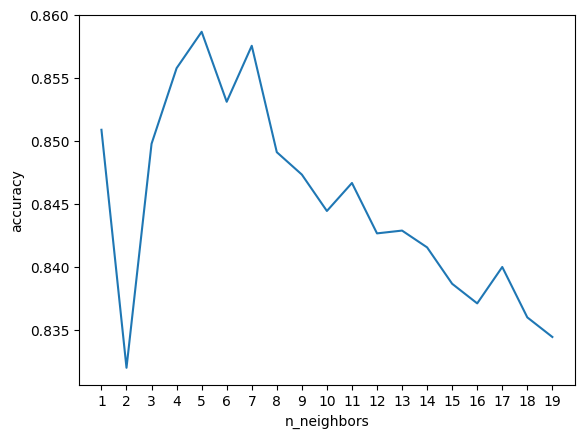

In [62]:
n_neighbors = range(1,20)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="euclidean", weights="uniform")
    clf.fit(X_train_norm, y_train)
    scores.append(clf.score(X_test_norm, y_test))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

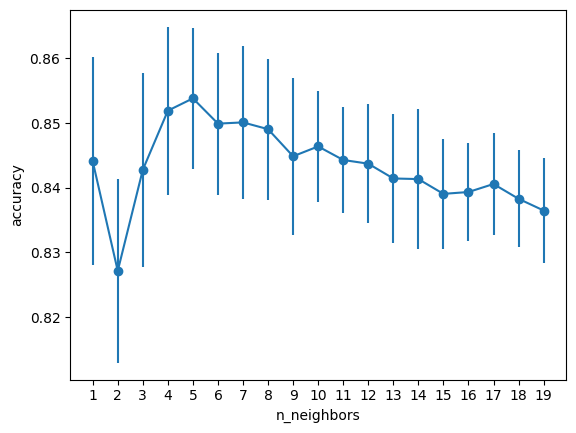

In [63]:
n_neighbors = range(1,20)
avg_scores = list()
std_scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="euclidean", weights="uniform")
    scores = cross_val_score(clf, X_train_norm, y_train, cv=k)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

#plt.plot(avg_scores)
plt.errorbar(range(len(n_neighbors)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

In [64]:
# clf = KNeighborsClassifier(n_neighbors=12, metric="euclidean", weights="uniform")
# clf.fit(X_train_norm, y_train)
# y_test_pred = clf.predict(X_test_norm)
# print("Accuracy:", accuracy_score(y_test, y_test_pred))

# Grid Search

In [65]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [66]:
param_grid = {
    "n_neighbors": np.arange(2, 15), 
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True, 
    # verbose=2
) 

grid.fit(X_train_norm, y_train)
clf = grid.best_estimator_

In [67]:
print(grid.best_params_, grid.best_score_)

{'metric': 'cityblock', 'n_neighbors': 8, 'weights': 'distance'} 0.9179904761904761


# Learning curve

train_sizes = np.linspace(0.1, 1.0, 10)

Questa riga crea un array di dieci numeri che sono equamente spaziati tra 0.1 e 1.0. Questi numeri rappresenteranno le proporzioni del set di allenamento che verranno utilizzate per generare la curva di apprendimento. Ad esempio, se hai 1000 esempi di allenamento, il primo punto della curva di apprendimento userà il 10% di questi dati, cioè 100 esempi.

estimator=clf

Qui, stai assegnando il tuo modello k-NN, che hai chiamato clf nello screenshot precedente, alla variabile estimator. Questo modello verrà utilizzato dalla funzione learning_curve per allenare e testare il modello.

X = df.drop('genre', axis=1)
y = df['genre']

Queste due righe selezionano le features e il target dal tuo DataFrame. X contiene tutte le colonne tranne 'genre', che è la colonna del target che si presume tu voglia prevedere. y contiene i valori della colonna 'genre'.

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

Qui, crei un oggetto StandardScaler, che normalizza i dati delle features sottraendo la media e dividendo per la deviazione standard. Poi utilizzi questo oggetto per trasformare i tuoi dati in X_norm, che sono i dati delle features normalizzati.

train_sizes, train_scores, test_scores = learning_curve(...)

Questa funzione calcola la curva di apprendimento. Allena il tuo modello (clf) su diverse porzioni del set di dati (definite da train_sizes) e calcola i punteggi di accuratezza sul training set e sul test set. La cross-validation a 10 fold (cv=10) è utilizzata per valutare l'accuratezza del modello, che significa che i dati vengono divisi in 10 parti, con 9 utilizzate per l'allenamento e 1 per il test, e questo processo è ripetuto 10 volte con parti diverse utilizzate come test set.

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Queste righe calcolano la media e la deviazione standard delle accuratezze ottenute durante la cross-validation sia per il training set sia per il test set. Ti permettono di vedere non solo come l'accuratezza cambia con diversi set di dati di allenamento, ma anche quanto sono variabili i risultati (indicati dalla deviazione standard).

Le ultime righe di codice (plt.figure(figsize=(10, 6)) fino a plt.show()) generano un grafico che mostra la curva di apprendimento. Mostrano l'accuratezza media sul training set e sul test set (anche chiamato validation set) in funzione della dimensione del training set, con le aree ombreggiate che rappresentano la deviazione standard. Il grafico è intitolato "Learning Curve for k-NN Classifier" e ha le etichette sugli assi appropriate per la dimensione dei dati di allenamento e l'accuratezza.

In [68]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Assicurati che Z_train, Z_test, t_train, e t_test siano definiti e che i tuoi dati siano già preelaborati
# Z_train, Z_test, t_train, t_test = ...

# Previsione delle probabilità per il set di test
y_score = clf.predict_proba(X_test_norm)

# Binarizza il vettore delle etichette in un formato "one-vs-all"
y_test_binarize = label_binarize(y_test, classes=np.unique(y_train))

# Calcola ROC curve e AUC per ciascuna classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_score.shape[1]

# Preparare i dati per il plot
traces = []

# Calcola la ROC curve per ogni classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    traces.append(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', 
                             name=f'Class {i} (AUC = {roc_auc[i]:.2f})'))

# Aggiungi la linea diagonale che rappresenta il caso di "indovinare casualmente"
traces.append(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
                         line=dict(dash='dash')))

# Crea il layout del plot
layout = go.Layout(title='Multiclass ROC Curve',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'),
                   width=1000,
                   height=800,
                   showlegend=True,
                   legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig = go.Figure(data=traces, layout=layout)
fig.show()
